# Setup

**Imports**

In [1]:
import datetime as dt
import re
from math import asin, cos, log, radians, sin, sqrt
from pprint import pprint
from typing import List, Tuple, Union

import contextily as cx
import geopandas
import IPython
import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ruptures as rpt
import seaborn as sns
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from matplotlib.axes import Axes
from matplotlib.dates import DateFormatter
from pygsp import graphs
from ruptures.base import BaseCost
from scipy.linalg import eigh
from scipy.signal import chirp, spectrogram, stft, sweep_poly
from scipy.spatial.distance import pdist, squareform

rng = np.random.default_rng()


**Utility functions**

In [2]:
tones = {
    "1": (697, 1209),
    "2": (697, 1336),
    "3": (697, 1477),
    "4": (770, 1209),
    "5": (770, 1336),
    "6": (770, 1477),
    "7": (852, 1209),
    "8": (852, 1336),
    "9": (852, 1477),
    "0": (941, 1336),
    "*": (941, 1209),
    "#": (941, 1477),
    "A": (697, 1633),
    "B": (770, 1633),
    "C": (852, 1633),
    "D": (941, 1633),
}
FS = 22_050  # Hz
sigma = 2


def generate_symbol(symbol, duration, fs):
    """Generate the sound for number with given duration"""
    # get both frequencies for the symbol
    f1, f2 = tones[symbol]
    # time array
    time_arr = np.arange(0, duration, 1 / fs)
    # audio signal
    signal = np.cos(2 * np.pi * f1 * time_arr) + np.cos(2 * np.pi * f2 * time_arr)
    return signal


def generate_signal():
    n_symbols = rng.integers(3, 12)
    list_of_symbols = rng.choice(list("1234567890*#ABCD"), size=n_symbols)

    list_of_segments = list()

    for symbol in list_of_symbols:
        duration = rng.uniform(low=0.05, high=0.2)  # seconds
        # generate tone
        symbol_signal = generate_symbol(symbol=symbol, duration=duration, fs=FS)
        # generate silence
        silence = np.zeros(int(duration * FS))
        # append tone and silence
        list_of_segments.extend([symbol_signal, silence])

    # silence at the start
    silence = np.zeros(int(duration * FS))
    list_of_segments = [silence] + list_of_segments

    signal = np.concatenate(list_of_segments)
    n_samples = signal.shape[0]
    time_array = np.arange(n_samples) / FS

    # add nuissance
    inst_freq = np.sin(2 * np.pi * 1.2 * time_array) * 1500 + 2000
    poly = np.polyfit(x=time_array, y=inst_freq, deg=14)
    sin_freq = sweep_poly(time_array, poly)
    signal += sin_freq
    # add white noise
    signal += rng.normal(scale=sigma, size=n_samples)

    return signal, list_of_symbols.tolist()


# Question 1


[Dual-tone multi-frequency signaling](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling) is a procedure to encode symbols using audio signal.

A symbold is represented by a sum of cosine waves: for $t=0,1,\dots,T-1$,

$$
y_t = \cos(2\pi f_1 t/f_s) + \cos(2\pi f_2 t/f_s)
$$
where each combination of $(f_1, f_2)$ represents a symbols (see table below).


|         | 1209 Hz  | 1336 Hz  | 1477 Hz  | 1633 Hz  |
|---------|----------|----------|----------|----------|
| **697 Hz**  | 1        | 2        | 3        | A        |
| **770 Hz**  | 4        | 5        | 6        | B        |
| **852 Hz**  | 7        | 8        | 9        | C        |
| **941 Hz**  | *        | 0        | #        | D        |

In [3]:
signal, symbols = generate_signal()
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)


6 4 D 9 * # 4


We first reconstruct the table above to suit our needs.

In [4]:
touches = [
    ["1", "2", "3", "A"],
    ["4", "5", "6", "B"],
    ["7", "8", "9", "C"],
    ["*", "0", "#", "D"],
]

f1 = np.array([697, 770, 852, 941])
f2 = np.array([1209, 1336, 1477, 1633])


We then create a training and validation dataset:

In [5]:
def generate_dataset(n: int = 100):
    signals = []
    labels = []
    for _ in range(n):
        signal, symbols = generate_signal()
        signals.append(signal)
        labels.append("".join(symbols))
    return signals, labels


train_signals, train_labels = generate_dataset(n=100)
val_signals, val_labels = generate_dataset(n=100)


We developped a full working pipeline on the train dataset, while we look for the best hyperparameters on the validation dataset.
Below is represented our complete pipeline, so the train dataset isn't a great use anymore.

**Full pipeline:**
* Compute the spectogram $S_{xx}$ of the signal
* Initialize a linearly penalized segmentation
* Initialize a penalty `pen_bic` $ = 9 \cdot 10^{-4} \sigma^2\log N$, with $\sigma=2$, the noise of the signal and $N$ the length of the signal.
* Fit the algorithm on the signal
* Post-process the found segmentations:
    * Find the 2 most common frequencies per segment as the brightest rows in the spectogram
    * Check if those 2 frequencies are not too far apart or too close, can they obey a dual-tone signal ?
    * Merge segments if they have the same symbol and are close enough
    * Keep only segments with enough energy in the spectrogram.

In [6]:
def predict_from_signal(
    signal: np.ndarray,
    nperseg: int = 512,
    noverlap: int = 6,
    min_size: int = 2,
    min_break_time: float = 0.2,
    min_energy: float = 0.1,
    ax: Axes = None,
) -> List[str]:
    """Predicts a list of symbols from a signal

    Args:
        signal (np.ndarray): signal (with noise ?)
        nperseg (int, optional): Length of each segment in the spectrogram. Defaults to 512.
        noverlap (int, optional): Number of points to overlap between segments in the spectrogram. Defaults to 6.
        min_size (int, optional): Minimum size of symbol in the spectrogram. Defaults to 2.
        min_break_time (float, optional): Minimum break time between 2 symbols, without being merged. Defaults to 0.2.
        min_energy (float, optional): Minimum energy of a symbol in the spectrogram for it to be considered. Defaults to 0.1.
        ax (Axes, optional): Axes to plot. Defaults to None.

    Returns:
        List[str]: list of symbols
    """
    # Estimate penalty
    pen_bic = 0.001 * sigma**2 * np.log(len(signal))

    # Compute spectrogram
    f, t, Sxx = spectrogram(signal, FS, nperseg=nperseg, noverlap=noverlap)

    # Compute studied windows
    min_freq = 650
    max_freq = 1800
    idx_min_freq = np.argmin(np.abs(f - min_freq))
    idx_max_freq = np.argmin(np.abs(f - max_freq))

    # Compute minimum and maximum distance (in Hz) between 2 frequencies
    # Those are the min and max distances found in the DTMF
    min_freq_dist = 250
    max_freq_dist = 950

    # Initialize algorithm
    algo = rpt.Pelt(model="l1", jump=1, min_size=min_size)

    # Fit and predict on signal
    predicted_bkps = algo.fit_predict(signal=Sxx.T, pen=pen_bic)

    # Display ?
    if ax is not None:
        ax.pcolormesh(t, f[0:100], Sxx[0:100, :])
        ax.set_ylabel("Frequency [Hz]")
        ax.set_xlabel("Time [sec]")

    # We iterate every 2 breakpoints
    # Odd breakpoints show symbols, even breakponts show silences
    predictions_segments = []
    for idx_bkp in range(0, len(predicted_bkps[:-2]), 2):
        # define start and end time
        start_time = t[predicted_bkps[idx_bkp]]
        end_time = (
            t[predicted_bkps[idx_bkp + 1]]
            if predicted_bkps[idx_bkp + 1] < len(t)
            else t[-1]
        )

        # define zone in spectrogram
        Sxx_zone = Sxx[
            idx_min_freq:idx_max_freq,
            predicted_bkps[idx_bkp] : predicted_bkps[idx_bkp + 1],
        ]

        # find the 2 frequencies with maximum energy in the spectrogram
        energy = np.mean(Sxx_zone, axis=1)
        freqs = f[idx_min_freq + np.argsort(energy)[-2:]]

        # if the 2 found frequencies are too far aport, or not enough, we discard them
        if (
            np.abs(freqs[0] - freqs[1]) < min_freq_dist
            or np.abs(freqs[0] - freqs[1]) > max_freq_dist
        ):
            continue

        # compute the closest frequencies in the DTMF
        distances_f1 = np.min(
            np.abs(f1[:None, None] - freqs[None, None, :]), axis=(0, 2)
        )
        distances_f2 = np.min(
            np.abs(f2[:None, None] - freqs[None, None, :]), axis=(0, 2)
        )
        pred_f1 = np.argmin(distances_f1)
        pred_f2 = np.argmin(distances_f2)

        # save segment
        predictions_segments.append(
            {
                "freqs": freqs,
                "symbol": touches[pred_f1][pred_f2],
                "start_time": start_time,
                "end_time": end_time,
                "energy": np.sum(np.sort(energy)[-2:]) / (end_time - start_time),
            }
        )

    # merge segments if they are close and have the same symbol
    whitelisted_segments = [predictions_segments[0]]
    for idx, next_segment in enumerate(predictions_segments[1:]):
        if (
            next_segment["symbol"] == whitelisted_segments[-1]["symbol"]
            and next_segment["start_time"] - whitelisted_segments[-1]["end_time"]
            < min_break_time
        ):
            whitelisted_segments[-1]["end_time"] = next_segment["end_time"]
        else:
            whitelisted_segments.append(next_segment)

    # only keep segment with enough energy
    whitelisted_segments = [
        segment for segment in whitelisted_segments if segment["energy"] > min_energy
    ]

    # display ?
    if ax is not None:
        for segment in whitelisted_segments:
            for freq in segment["freqs"]:
                ax.axhline(
                    freq,
                    xmin=segment["start_time"] / t[-1],
                    xmax=segment["end_time"] / t[-1],
                    color="red",
                )
            ax.text(
                segment["start_time"],
                np.max(segment["freqs"]) + 200,
                segment["symbol"],
                size=30,
                color="red",
            )

    predicted_symbols = [segment["symbol"] for segment in whitelisted_segments]
    return predicted_symbols


In [7]:
def accuracy_score(
    y_true: Union[List[str], List[List[str]]], y_pred: Union[List[str], List[List[str]]]
) -> Tuple[float, float]:
    """Compute the accuracy score between a set of prediction a set of labels

    Args:
        y_true (Union[List[str], List[List[str]]]): List of true labels, eg ["B91", "CD"] or [["B", "9", "4"], ["C", "D"]]
        y_pred (Union[List[str], List[List[str]]]): List of predictions, eg ["B81", "CE"] or [["B", "8", "4"], ["C", "E"]]

    Returns:
        Tuple[float, float]: list of accuracies per label
    """
    accuracies = []
    for label, prediction in zip(y_true, y_pred):
        if isinstance(label, list):
            label = "".join(label)
        if isinstance(prediction, list):
            prediction = "".join(prediction)
        distance = Levenshtein.distance(prediction, label)
        accuracy = 1 - distance / max(len(label), len(prediction))
        accuracies.append(accuracy)
    accuracies = np.array(accuracies)
    return accuracies


Predictions on the validation set:

In [8]:
predictions = [predict_from_signal(signal) for signal in val_signals]
accuracies = accuracy_score(val_labels, predictions)
print(
    "Accuracy score: {:.2f}% (+- {:.2f})".format(
        100 * np.mean(accuracies), 100 * np.std(accuracies)
    )
)


Accuracy score: 78.19% (+- 17.71)


We notice that the accuracy score is pretty good. However, it has a huge standard deviation.

We now plot the best and worst predictions.

Text(0.5, 1.0, 'Best prediction')

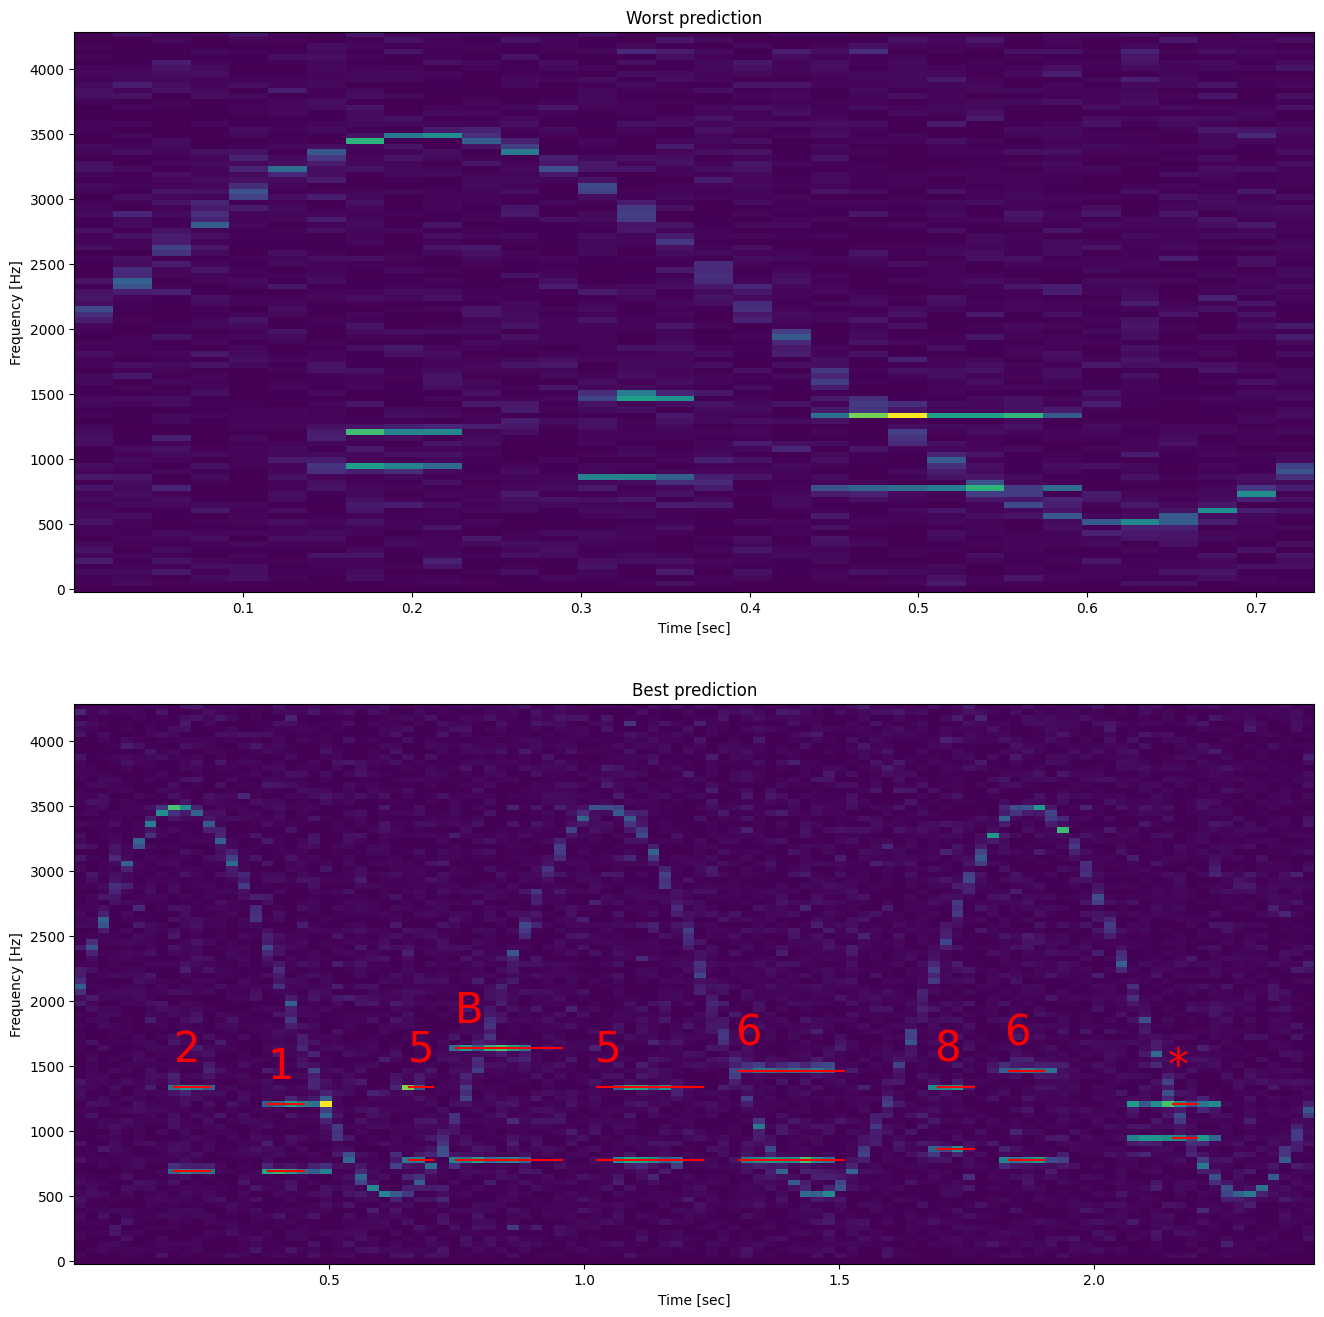

In [9]:
# idx worst prediction
idx_min = np.argmin(accuracies)

# idx best prediction
perfect_match = np.arange(len(accuracies))[accuracies == 1]
perfect_match_length = [
    len(pred) for pred in np.array(predictions, dtype="object")[perfect_match]
]
idx_max = perfect_match[np.argsort(perfect_match_length)[-1]]

fig, axs = plt.subplots(2, 1, figsize=(16, 16))
_ = predict_from_signal(val_signals[idx_min], ax=axs[0])
_ = predict_from_signal(val_signals[idx_max], ax=axs[1])
axs[0].set_title("Worst prediction")
axs[1].set_title("Best prediction")


Above are plotted the best and worst detections. We notice that the worst predictions often occurs with smaller signals. Indeed, small signals arise problems when computing the spectrogram as it becomes more pixelated. 

This also induces some bias in our accuracy metric. Indeed, our metric is the ratio of number of deletions / additions / substitutions divided by the number of symbols. As we are doing more error in short sequences, these errors have a much lower accuracy score, resulting in a huge standard deviation on the whole accuracy score. 

# Question 2

Predicted symbols Sound 1: B94B38B#1
Predicted symbols Sound 2: CD11263


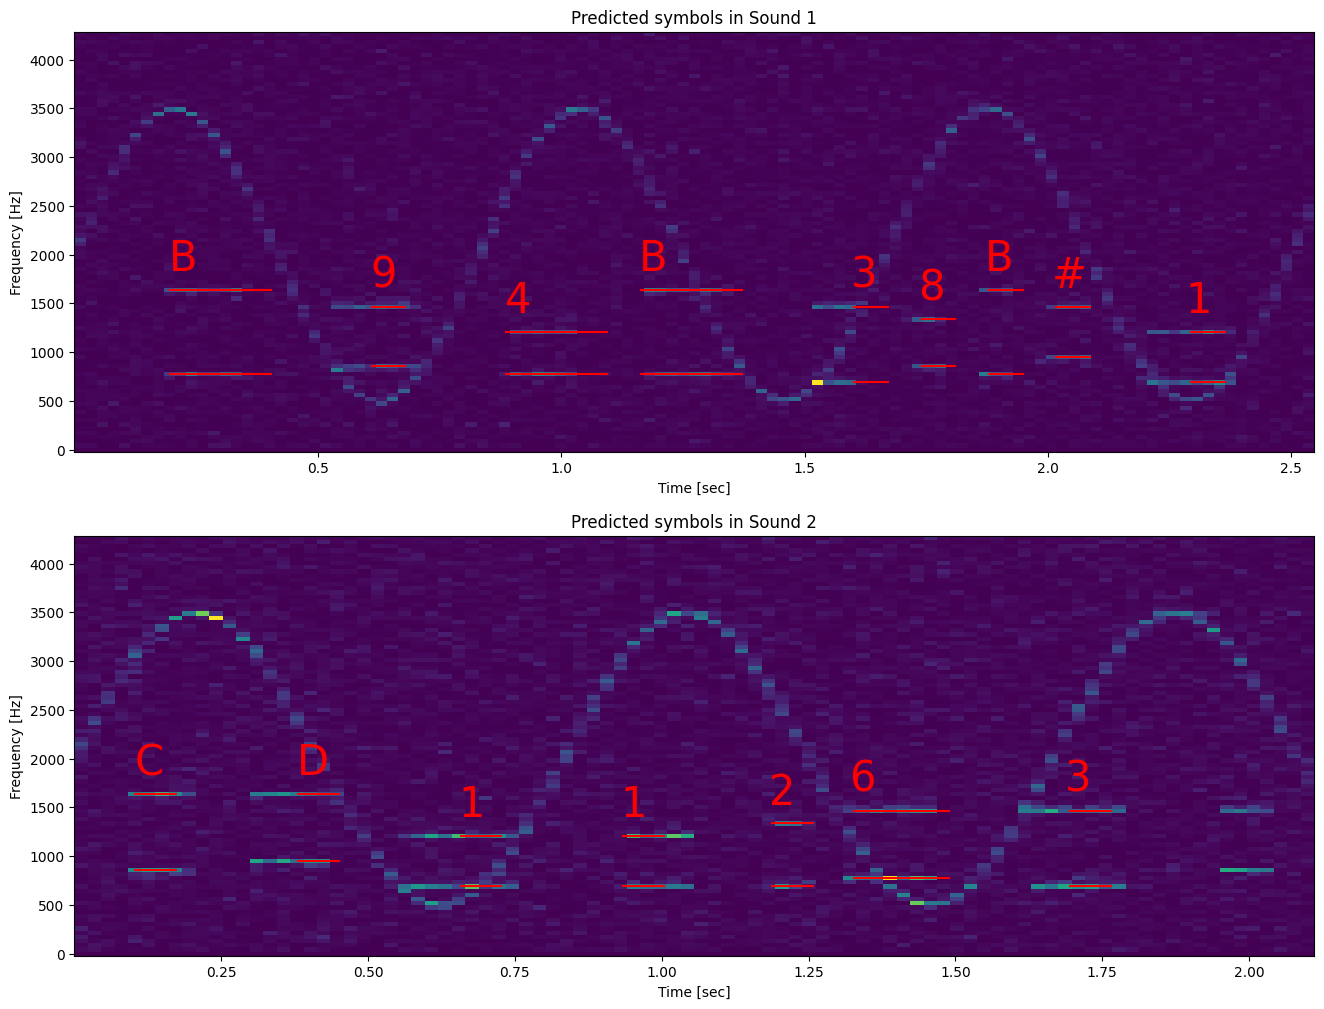

In [10]:
sound_1 = np.loadtxt("signal_1.csv")
sound_2 = np.loadtxt("signal_2.csv")

fig, axs = plt.subplots(2, 1, figsize=(16, 12))
sound_1_symbols = predict_from_signal(sound_1, ax=axs[0])
sound_2_symbols = predict_from_signal(sound_2, ax=axs[1])
axs[0].set_title("Predicted symbols in Sound 1")
axs[1].set_title("Predicted symbols in Sound 2")

print("Predicted symbols Sound 1:", "".join(sound_1_symbols))
print("Predicted symbols Sound 2:", "".join(sound_2_symbols))


# Question 3

In [11]:
M = 9
lambda_n = 12
R = 5


def gu(lambd, a, R):
    characteristic = np.logical_and(-R * a <= lambd, lambd <= 0).astype(float)
    cos = np.cos(2 * np.pi * (lambd / (a * R) + 0.5))
    return 0.5 * (1 + cos) * characteristic


def gm(lambd, m, R, M=M):
    a = lambda_n / (M + 1 - R)
    return gu(lambd - a * m, a, R)


lambd = np.linspace(-15, 25, 1000)
g_R1 = np.stack([gm(lambd, i, R=1, M=M) for i in range(1, 9)])
g_R3 = np.stack([gm(lambd, i, R=3, M=M) for i in range(1, 9)])
g_R5 = np.stack([gm(lambd, i, R=5, M=M) for i in range(1, 9)])


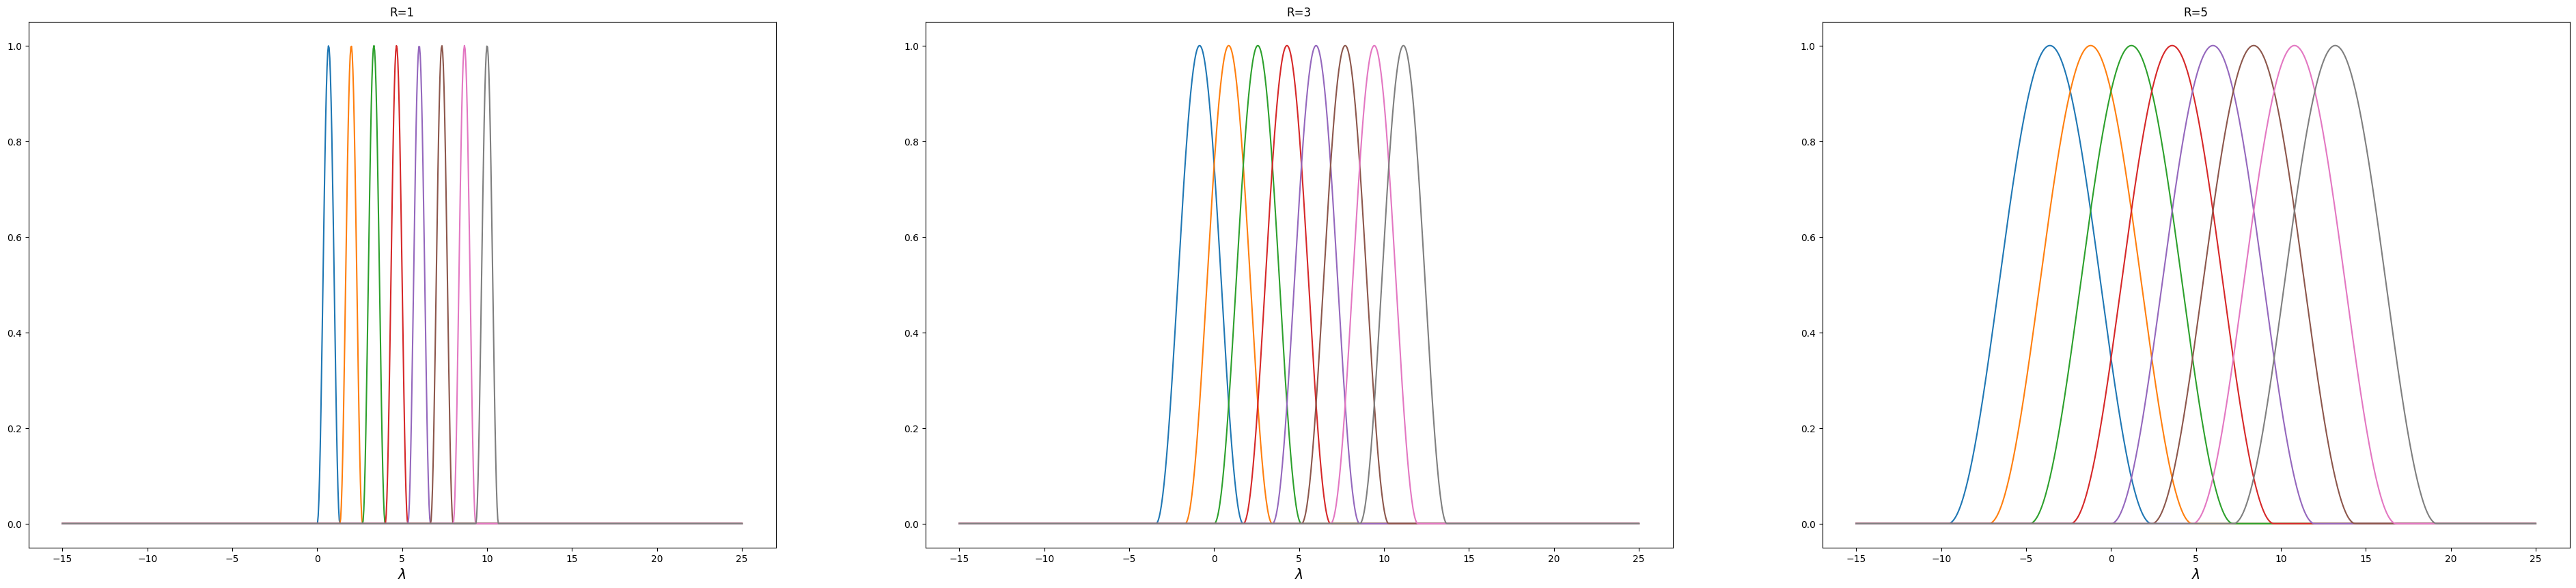

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(48, 10))
for idx, (R, g) in enumerate({"1": g_R1, "3": g_R3, "5": g_R5}.items()):
    axs[idx].plot(lambd, g.T)
    axs[idx].set_xlabel(r"$\lambda$", fontsize=15)
    axs[idx].set_title(f"R={R}")


# Question 4

In [13]:
CRS = "EPSG:4326"


In [14]:
def load_data(whiteslist_stations=None):
    data_df, stations_df, description = load_molene_meteo_dataset()
    data_df["temp"] = data_df.t - 273.15

    if whiteslist_stations is not None:
        keep_cond = stations_df.Nom.isin(whiteslist_stations)
        stations_df = stations_df[keep_cond]

        keep_cond = data_df.station_name.isin(whiteslist_stations)
        data_df = data_df[keep_cond].reset_index().drop("index", axis="columns")

    temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
    return data_df, stations_df, temperature_df


data_df, stations_df, temperature_df = load_data(whiteslist_stations=None)
nan_stations = temperature_df.columns[temperature_df.isna().any()].tolist()
station_list = list(set(temperature_df.columns) - set(nan_stations))
print(f"Stations containing at least one nan value: {nan_stations}")


Stations containing at least one nan value: ['ARZAL', 'BATZ', 'BEG_MEIL', 'BREST-GUIPAVAS', 'BRIGNOGAN', 'CAMARET', 'LANDIVISIAU', 'LANNAERO', 'LANVEOC', 'OUESSANT-STIFF', 'PLOUAY-SA', 'PLOUDALMEZEAU', 'PLOUGONVELIN', 'QUIMPER', 'RIEC SUR BELON', 'SIZUN', 'ST NAZAIRE-MONTOIR', 'VANNES-MEUCON']


In [15]:
data_df, stations_df, temperature_df = load_data(whiteslist_stations=station_list)
# convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(stations_df.Longitude, stations_df.Latitude),
).set_crs(CRS)


Threshold: 0.8318
The graph is connected, with average degree 4.05


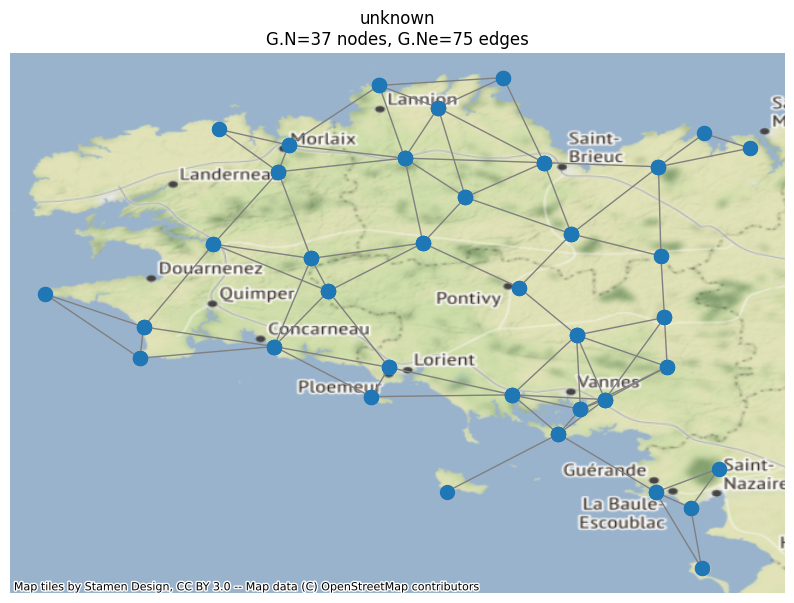

In [16]:
def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r


def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    """Computes the exponantial similarity from a squared distance matrix"""
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr


# computes the distance matrix
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
sigma = np.median(dist_mat_condensed)  # median heuristic

# find the maximum threshold of a connected graph
thresholds = np.linspace(1, 0, 1000)
threshold = 0
for i in range(len(thresholds)):
    adjacency_matrix_gaussian = squareform(
        get_exponential_similarity(dist_mat_condensed, sigma, thresholds[i])
    )
    graph = graphs.Graph(adjacency_matrix_gaussian)
    if graph.is_connected(recompute=True) and np.mean(graph.d) > 3:
        threshold = thresholds[i]
        break

print("Threshold: {:.4f}".format(threshold))
print(
    f"The graph is {'not ' if not graph.is_connected(recompute=True) else ''}connected, with average degree {np.mean(graph.d):.2f}"
)

ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
graph.set_coordinates(stations_np)
graph.plot(ax=ax)


In [17]:
laplacian = graph.L.todense()
smoothnesses = []
for idx in range(len(temperature_df)):
    smoothnesses.append(
        temperature_df.iloc[idx].T @ laplacian @ temperature_df.iloc[idx]
    )
smoothnesses = np.array(smoothnesses)

idx_min = np.argmin(smoothnesses)
idx_max = np.argmax(smoothnesses)
print("Average smoothness: {:.2f}".format(np.mean(smoothnesses)))
print("Least smooth day: {}".format(temperature_df.index[idx_max]))
print("Smoothest day: {}".format(temperature_df.index[idx_min]))


Average smoothness: 326.77
Least smooth day: 2014-01-10 09:00:00
Smoothest day: 2014-01-24 19:00:00


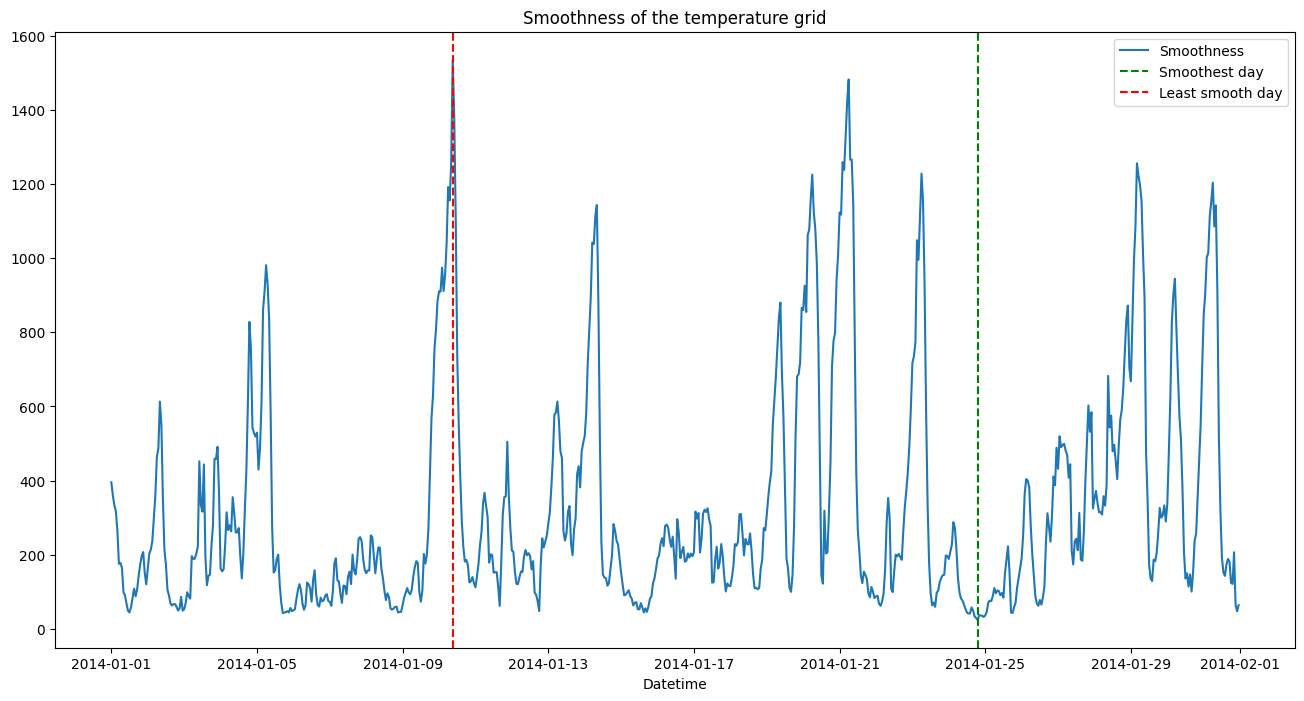

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(temperature_df.index, smoothnesses, label="Smoothness")
ax.set_xlabel("Datetime")
ax.set_title("Smoothness of the temperature grid")
ax.axvline(
    x=temperature_df.index[idx_min],
    ymin=0,
    ymax=np.max(smoothnesses),
    label="Smoothest day",
    color="green",
    linestyle="--",
)
ax.axvline(
    x=temperature_df.index[idx_max],
    ymin=0,
    ymax=np.max(smoothnesses),
    label="Least smooth day",
    color="red",
    linestyle="--",
)
ax.legend(loc="upper right")
plt.show()


# Question 5

In [19]:
def compute_W_at_index(signal, graph, M=M):
    """
    Computes the W matrix over the graph given a signal. W is a matrix of size M x Number of nodes in the graph
    """
    eigenvals, eigenvects = eigh(graph.L.todense())  # columns are eigenvectors

    W = np.zeros((M, len(eigenvects)))
    g = np.stack(
        [gm(eigenvals, i, R=3, M=M) for i in range(1, 10)]
    )  # size M x eigenvals
    f_hat = signal.T @ eigenvects
    for idx, v in enumerate(eigenvects):
        ul_v = eigenvects[
            idx, :
        ]  # vector of length eigenvals, corresponds to the coordinates of every eigenvect at v
        w = g * f_hat[None, :] * ul_v[None, :]  # w of size M x eigenvals
        W[:, idx] = np.sum(w, axis=1)  # sum over all eigen vals
    return W


def classify_W(W):
    """
    Transforms a real valued W matrix into a vector of length number of nodes, encoding the class of the nodes among [low, medium, high]
    """
    low_frequency = np.sum(np.abs(W[:3, :]), axis=0)
    med_frequency = np.sum(np.abs(W[3:6, :]), axis=0)
    high_frequency = np.sum(np.abs(W[6:, :]), axis=0)
    energy = np.stack([low_frequency, med_frequency, high_frequency])
    return np.argmax(energy, axis=0)


In [20]:
W_init = compute_W_at_index(temperature_df.iloc[0], graph, M=M)  # W at first day
W_smoothest = compute_W_at_index(
    temperature_df.iloc[idx_min], graph, M=M
)  # W at smoothest day
W_least_smooth = compute_W_at_index(
    temperature_df.iloc[idx_max], graph, M=M
)  # W at least smooth day

W_init_classified = classify_W(W_init)
W_smoothest_classified = classify_W(W_smoothest)
W_least_smooth_classified = classify_W(W_least_smooth)


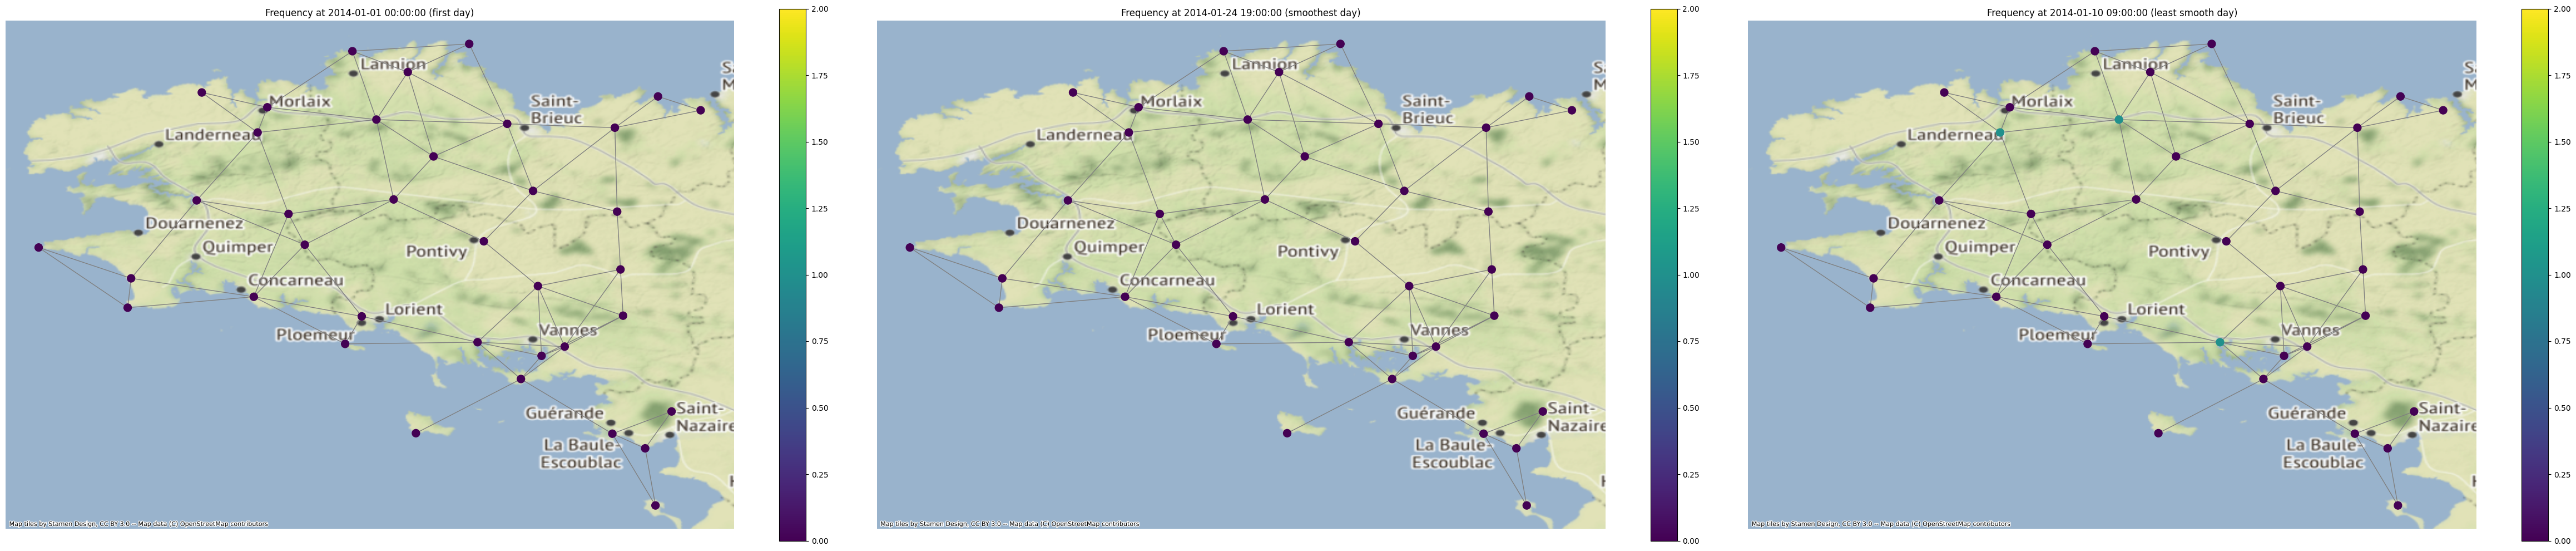

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(48, 10))

for idx, (day, W) in enumerate(
    {
        f"{temperature_df.index[0]} (first day)": W_init_classified,
        f"{temperature_df.index[idx_min]} (smoothest day)": W_smoothest_classified,
        f"{temperature_df.index[idx_max]} (least smooth day)": W_least_smooth_classified,
    }.items()
):
    ax = axs[idx]
    ax = stations_gdf.geometry.plot(figsize=(10, 5), ax=ax)
    cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
    ax.set_axis_off()
    graph.set_coordinates(stations_np)
    graph.plot_signal(W, ax=ax, limits=[0, 2])
    ax.set_title(f"Frequency at {day}")
plt.tight_layout()


# Question 6

In [22]:
major_class = []
for timestamp in temperature_df.index:
    W = compute_W_at_index(temperature_df.loc[timestamp], graph)
    W_classified = classify_W(W)
    values, counts = np.unique(W_classified, return_counts=True)
    major_value = values[np.argmax(counts)]
    major_class.append(major_value)
major_class = np.array(major_class)


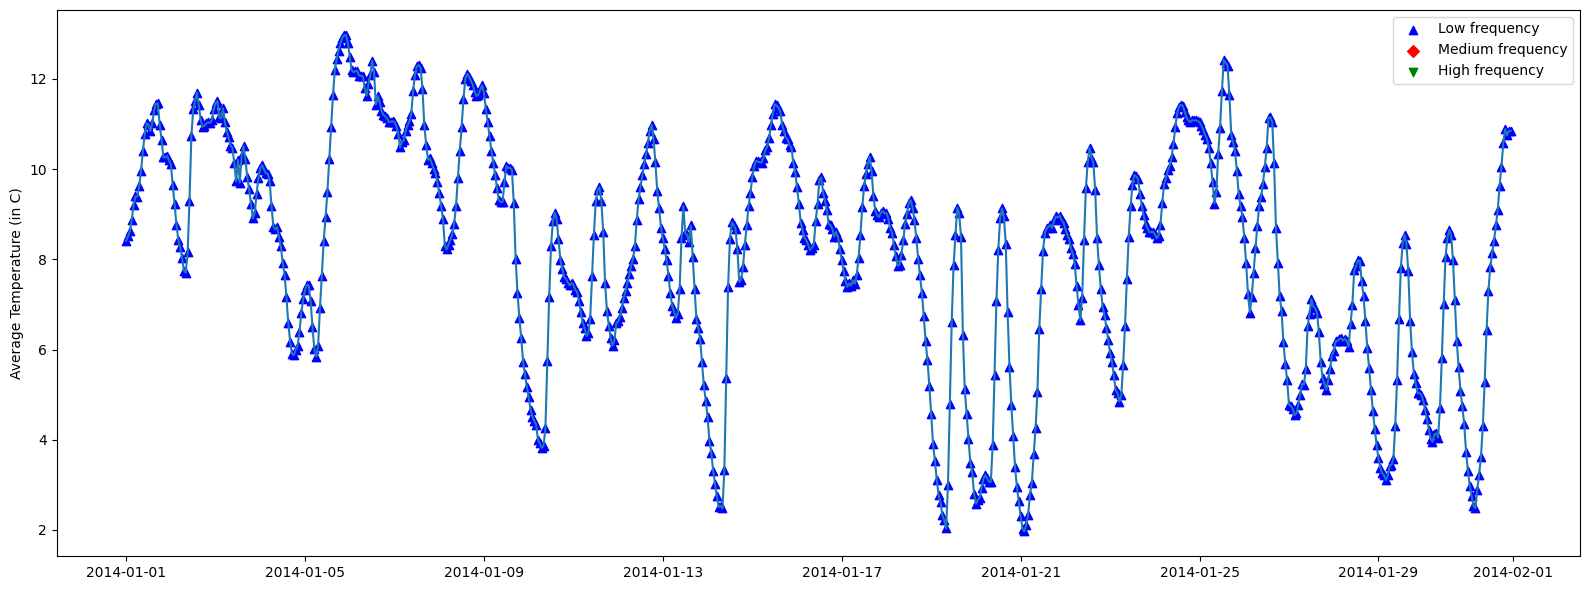

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.plot(temperature_df.index, temperature_df.T.mean())
marker_list = ["^", "D", "v"]
color_list = ["blue", "red", "green"]
for major_value in [0, 1, 2]:
    mask = major_class == major_value
    ax.scatter(
        np.array(temperature_df.index)[mask],
        np.array(temperature_df.T.mean())[mask],
        color=color_list[major_value],
        marker=marker_list[major_value],
        label=["Low frequency", "Medium frequency", "High frequency"][major_value],
    )
ax.set_ylabel("Average Temperature (in C)")
ax.legend()
plt.tight_layout()


# Question 7

In [24]:
# define the line graph
adjacency_line = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
line_graph = graphs.Graph(adjacency_line)


def find_eig(graph_a, graph_b):
    """Computes the eigenvalues and eigenvectors of the product graph"""
    eigenvals_a, eigenvects_a = eigh(graph_a.L.todense())  # columns are eigenvectors
    eigenvals_b, eigenvects_b = eigh(graph_b.L.todense())  # columns are eigenvectors

    eigenvals = []
    eigenvects = []
    for eigenval_a, eigenvect_a in zip(eigenvals_a, eigenvects_a):
        for eigenval_b, eigenvect_b in zip(eigenvals_b, eigenvects_b):
            eigenvals.append(eigenval_a + eigenval_b)
            eigenvects.append(np.kron(eigenvect_a, eigenvect_b))

    idx = np.argsort(eigenvals)
    eigenvals = np.array(eigenvals)[idx]
    eigenvects = np.array(eigenvects)[idx]
    return eigenvals, eigenvects.T  # transpose so the vectors are in column


def compute_dyna_W_at_index(signal, graph_a, graph_b, M=M):
    """
    Computes the W matrix over the graph given a signal. W is a matrix of size M x Number of nodes in the graph
    """
    eigenvals, eigenvects = find_eig(graph_a, graph_b)

    W = np.zeros((M, len(eigenvects)))
    g = np.stack(
        [gm(eigenvals, i, R=3, M=M) for i in range(1, 10)]
    )  # size M x eigenvals
    f_hat = signal.T @ eigenvects
    for idx, v in enumerate(eigenvects):
        ul_v = eigenvects[
            idx, :
        ]  # vector of length eigenvals, corresponds to the coordinates of every eigenvect at v
        w = g * f_hat[None, :] * ul_v[None, :]  # w of size M x eigenvals
        W[:, idx] = np.sum(w, axis=1)  # sum over all eigen vals
    return W

# We flatten the signal and feed it to the computation of W
dynamic_init_signal = np.array(temperature_df.iloc[1:4].T).flatten()
W_init_dyna = compute_dyna_W_at_index(dynamic_init_signal, graph, line_graph, M=M)

dynamic_smoothest_signal = np.array(
    temperature_df.iloc[idx_min - 1 : idx_min + 2].T
).flatten()
W_smoothest_dyna = compute_dyna_W_at_index(
    dynamic_smoothest_signal, graph, line_graph, M=M
)

dynamic_least_smooth_signal = np.array(
    temperature_df.iloc[idx_max - 1 : idx_max + 2].T
).flatten()
W_least_smooth_dyna = compute_dyna_W_at_index(
    dynamic_least_smooth_signal, graph, line_graph, M=M
)


In [25]:
# We then reshape the dynamic matrices W
W_init_dyna_reshape = W_init_dyna.reshape((M, len(station_list), -1))
W_smoothest_dyna_reshape = W_smoothest_dyna.reshape((M, len(station_list), -1))
W_least_smooth_dyna_reshape = W_least_smooth_dyna.reshape((M, len(station_list), -1))

# We finally sum all the W coefficients over the time axis
W_init_dyna_reshape = W_init_dyna_reshape.sum(axis=2)
W_smoothest_dyna_reshape = W_smoothest_dyna_reshape.sum(axis=2)
W_least_smooth_dyna_reshape = W_least_smooth_dyna_reshape.sum(axis=2)

In [26]:
# We then classify the big W matrices
W_init_dyna_classified = classify_W(W_init_dyna_reshape)
W_smoothest_dyna_classified = classify_W(W_smoothest_dyna_reshape)
W_least_smooth_dyna_classified = classify_W(W_least_smooth_dyna_reshape)


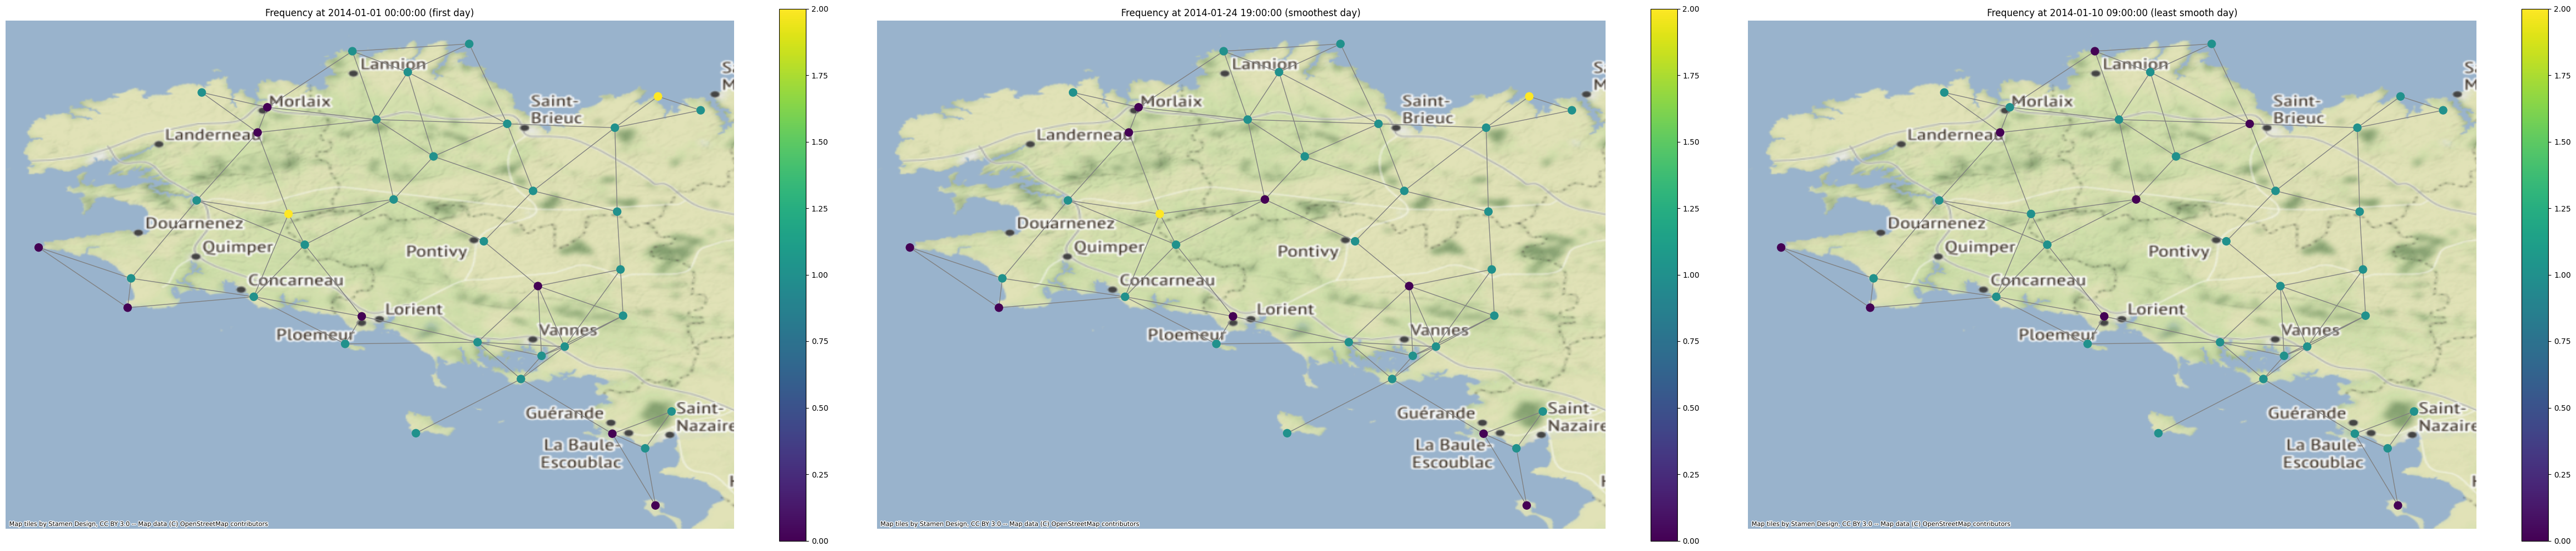

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(48, 10))

for idx, (day, W) in enumerate(
    {
        f"{temperature_df.index[0]} (first day)": W_init_dyna_classified,
        f"{temperature_df.index[idx_min]} (smoothest day)": W_smoothest_dyna_classified,
        f"{temperature_df.index[idx_max]} (least smooth day)": W_least_smooth_dyna_classified,
    }.items()
):
    # we reshape W, and only keep the middle column which 
    ax = axs[idx]
    ax = stations_gdf.geometry.plot(figsize=(10, 5), ax=ax)
    cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
    ax.set_axis_off()
    graph.set_coordinates(stations_np)
    graph.plot_signal(W, ax=ax, limits=[0, 2])
    ax.set_title(f"Frequency at {day}")
plt.tight_layout()


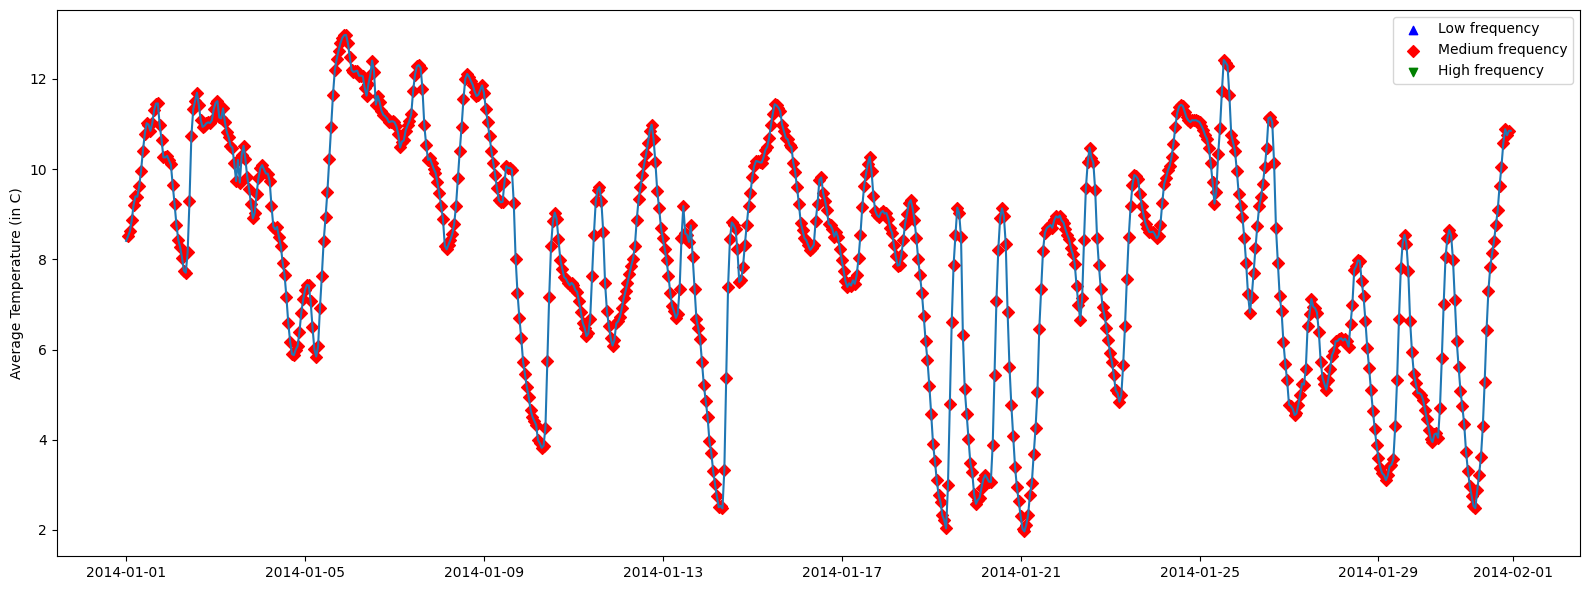

In [28]:
major_class = []
for idx in range(1, len(temperature_df) - 1):
    W = compute_dyna_W_at_index(
        temperature_df.iloc[idx - 1 : idx + 2].to_numpy().flatten(), graph, line_graph
    )
    # We then reshape the dynamic matrices W
    W_reshape = W.reshape((M, len(station_list), -1))

    # We finally sum all the W coefficients over the time axis
    W_reshape = W_reshape.sum(axis=2)
    W_classified = classify_W(W_reshape)
    values, counts = np.unique(W_classified, return_counts=True)
    major_value = values[np.argmax(counts)]
    major_class.append(major_value)
major_class = np.array(major_class)


fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.plot(temperature_df.index, temperature_df.T.mean())
marker_list = ["^", "D", "v"]
color_list = ["blue", "red", "green"]
for major_value in [0, 1, 2]:
    mask = major_class == major_value
    ax.scatter(
        np.array(temperature_df.index[1:-1])[mask],
        np.array(temperature_df.T.mean()[1:-1])[mask],
        color=color_list[major_value],
        marker=marker_list[major_value],
        label=["Low frequency", "Medium frequency", "High frequency"][major_value],
    )
ax.set_ylabel("Average Temperature (in C)")
ax.legend()
plt.tight_layout()
plt.savefig("q7.jpg", dpi=300)

Our algorithm is probably not working, as the predicted frequency is always the same.